<a href="https://www.kaggle.com/code/idrisoduola/understanding-pytorch-lightning-with-mnist?scriptVersionId=234134562" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import pytorch_lightning as pl
import torchmetrics
from torchmetrics import Metric

## The Lightning Module

In [2]:
#With Lightning
class NN_pl(pl.LightningModule):
  def __init__(self, input_size, no_of_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size, 50)
    self.fc2 = nn.Linear(50, no_of_classes)
    self.loss_fn = nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = no_of_classes)
    self.f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = no_of_classes)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  #We will define a training step, there will be no need for zero_grad, backward, or the step. We can also utilize a common step function
  #to share between the similar steps
  def training_step(self, batch, batch_idx):
    loss, scores, y = self._common_step(batch, batch_idx)
    accuracy = self.accuracy(scores, y)
    f1_score = self.f1_score(scores, y)
    self.log_dict({"train_loss": loss, "train_accuracy": accuracy, "train_f1_score": f1_score},on_step = False,
                  on_epoch = True, prog_bar = True)
    return loss

  def validation_step(self, batch, batch_idx):
    loss, scores, y = self._common_step(batch, batch_idx)
    self.log("loss", loss)
    return loss

  def test_step(self, batch, batch_idx):
    loss, scores, y = self._common_step(batch, batch_idx)
    self.log("test_loss", loss, on_step=True, on_epoch=True)
    return loss

  def _common_step(self, batch, batch_idx):
    x,y = batch
    x = x.reshape(x.shape[0], -1)
    scores = self(x) #The call method in nn module runs the forward method
    loss = self.loss_fn(scores,y)
    return loss, scores, y

  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr = lr)

  def predict_step(self, batch, batch_idx):
    x,y = batch
    x = x.reshape(x.shape[0], -1)
    scores = self(x)
    preds = torch.argmax(scores, dim=1)
    return preds, y, batch[0]

  #Between each epoch we might want to compute some metrics, so we can add that as a method too
  #def training_epoch_end(self, outputs):
    


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## The Dataset

In [4]:
#Hyperparameters (NOt using the config setup)
input_size = 784
no_of_classes = 10
lr = 0.001
batch_size = 64
num_epochs = 3

In [6]:
#Load Data directly without the datamodule
entire_dataset = datasets.MNIST(
    root = "dataset/", train = True, transform = transforms.ToTensor(), download = True
)
#
train_ds, val_ds = random_split(entire_dataset, [50000, 10000])
test_ds = datasets.MNIST(
    root = "dataset/", train = False, transform = transforms.ToTensor(), download = True
)
train_loader = DataLoader(dataset = train_ds, batch_size = batch_size, shuffle = True, num_workers = 3) #Easier dataset management
val_loader = DataLoader(dataset = val_ds, batch_size = batch_size, shuffle = False, num_workers = 3) 

test_loader = DataLoader(dataset = test_ds, batch_size = batch_size, shuffle = False, num_workers = 3)

Images shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


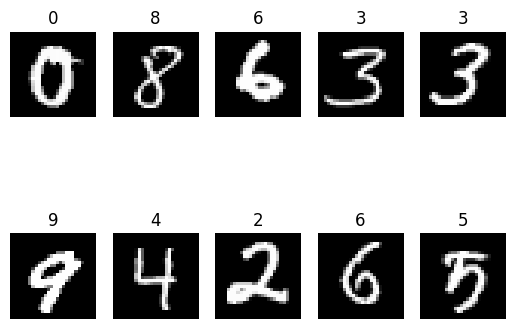

In [7]:
import matplotlib.pyplot as plt
#Viewing the datasets in the trainloader
images, label = next(iter(train_loader))
print("Images shape:", images.shape)
print("Label shape:", label.shape)

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(images[i][0], cmap = "gray")
  plt.title(label[i].item())
  plt.axis("off")
plt.show()

## Trainer

In [8]:
model = NN_pl(input_size=input_size, no_of_classes=no_of_classes).to(device)
trainer = pl.Trainer(accelerator = 'gpu', min_epochs = 1, max_epochs = 3)
trainer.fit(model, train_loader)
trainer.validate(model,val_loader)
trainer.test(model,test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           loss            │    0.16728438436985016    │
└───────────────────────────┴───────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.15325549244880676    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.15325549244880676}]

### Visualizing Models Wrong Predictions 

In [9]:
results = trainer.predict(model, test_loader)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
all_preds, all_targets, all_batches = zip(*results)
preds = torch.cat(all_preds)
targets = torch.cat(all_targets)
batches = torch.cat(all_batches)

print(f"Prediction has shape: {preds.shape}, targets has shape: {targets.shape}, batches has shape: {batches.shape}")

Prediction has shape: torch.Size([10000]), targets has shape: torch.Size([10000]), batches has shape: torch.Size([10000, 1, 28, 28])


In [11]:
num_incorrect = 0
incorrect = preds != targets
num_incorrect += incorrect.sum()
print(f"Number of incorrect predictions are {num_incorrect}")

incorrect_pred = preds[incorrect]
incorrect_targets = targets[incorrect]
incorrect_images = batches[incorrect]

Number of incorrect predictions are 470


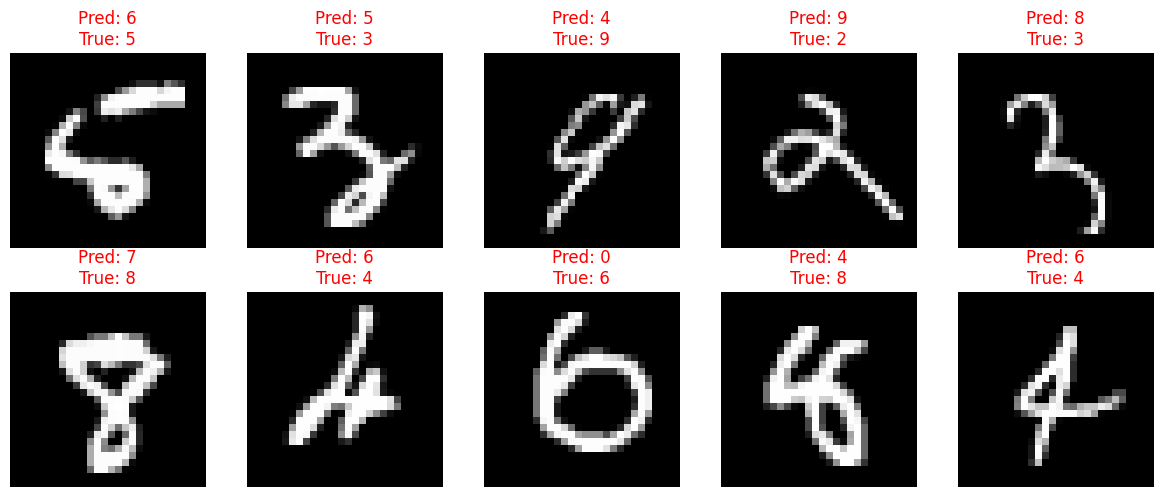

In [12]:
num_of_plot = min(10, num_incorrect)
plt.figure(figsize=(12,5))
for i in range(num_of_plot):
    plt.subplot(2,5, i+1)
    plt.imshow(incorrect_images[i].squeeze(), cmap = 'gray')
    plt.title(f"Pred: {incorrect_pred[i].item()}\nTrue: {incorrect_targets[i].item()}", color="red")
    plt.axis("off")
plt.tight_layout()
plt.show()


#### Reference: www.youtube.com/@AladdinPersson